# Solving Math Word Problems with a Seq2Seq Transformer

## Importing necessary libraries

In [1]:
import pathlib
import random
import string
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Getting the data

In [2]:
!git clone https://github.com/openai/grade-school-math

Cloning into 'grade-school-math'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 36 (delta 10), reused 7 (delta 7), pack-reused 16
Unpacking objects: 100% (36/36), 3.13 MiB | 3.22 MiB/s, done.


In [3]:
%cd grade-school-math/grade_school_math/data
%ls

/kaggle/working/grade-school-math/grade_school_math/data
example_model_solutions.jsonl  test_socratic.jsonl  train_socratic.jsonl
test.jsonl                     train.jsonl


In [4]:
def read_jsonl(path: str):
    with open(path) as fh:
        return [json.loads(line) for line in fh.readlines() if line]

train = read_jsonl('train.jsonl')
test = read_jsonl('test.jsonl')
print(len(train), 'training pairs')
print(len(test), 'test pairs')

7473 training pairs
1319 test pairs


In [5]:
print(train[0])

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}


In [6]:
train_pairs = []
for line in train:
    question = line['question']
    answer = '[start] ' + line['answer'] + ' [end]'
    train_pairs.append((question, answer))

test_pairs = []
for line in test:
    question = line['question']
    answer = '[start] ' + line['answer'] + ' [end]'
    test_pairs.append((question, answer))

for _ in range(5):
    print(random.choice(train_pairs))

('Michelle had some leftover cans of silly string from her birthday party. She split them among Roger and 3 of his friends. Then Roger decided to give 2 of his cans to his brothers so that he now has 4 for himself. How many cans of silly string did Michelle have to start with?', '[start] Roger originally had 4 cans of silly string + 2 can he gave to his brothers = <<4+2=6>>6 cans.\nSince his friends received the same amount as Roger did originally, 3 friends x 6 cans of silly string = <<3*6=18>>18 cans.\nMichelle started with 6 cans that went to Roger + 18 cans that went to his friends = <<6+18=24>>24 cans of silly string.\n#### 24 [end]')
('When three friends sold their video games, Ryan, the first of the three friends, received $50 more than Jason from his sales. Jason received 30% more money than Zachary from selling his video games. If Zachary sold 40 games at $5 each, calculate the total amount of money the three friends received together from the sale of the video games.', '[star

In [7]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 100
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


question_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
answer_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_questions = [pair[0] for pair in train_pairs]
train_answers = [pair[1] for pair in train_pairs]
question_vectorization.adapt(train_questions)
answer_vectorization.adapt(train_answers)

2022-10-18 19:34:44.940208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 19:34:45.040831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 19:34:45.041626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 19:34:45.042718: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
def format_dataset(question, answer):
    question = question_vectorization(question)
    answer = answer_vectorization(answer)
    return ({"encoder_inputs": question, "decoder_inputs": answer[:, :-1],}, answer[:, 1:])


def make_dataset(pairs):
    question_texts, answer_texts = zip(*pairs)
    question_texts = list(question_texts)
    answer_texts = list(answer_texts)
    dataset = tf.data.Dataset.from_tensor_slices((question_texts, answer_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
# val_ds = make_dataset(val_pairs)

## Model construction

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

## Data vectorization

In [10]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    3865600     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 256)    3155456     positional_embedding[0][0]       
________________________________________________________________________________________

In [11]:
epochs = 200

transformer.compile(
    'rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy']
)
history = transformer.fit(train_ds, epochs=epochs)

Epoch 1/200


2022-10-18 19:35:03.148747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


117/117 [==============================] - 24s 157ms/step - loss: 3.2131 - accuracy: 0.0709
Epoch 2/200
117/117 [==============================] - 18s 156ms/step - loss: 2.7536 - accuracy: 0.1678
Epoch 3/200
117/117 [==============================] - 18s 157ms/step - loss: 2.5546 - accuracy: 0.1978
Epoch 4/200
117/117 [==============================] - 18s 157ms/step - loss: 2.4593 - accuracy: 0.2168
Epoch 5/200
117/117 [==============================] - 18s 157ms/step - loss: 2.3503 - accuracy: 0.2363
Epoch 6/200
117/117 [==============================] - 18s 157ms/step - loss: 2.2796 - accuracy: 0.2518
Epoch 7/200
117/117 [==============================] - 18s 156ms/step - loss: 2.2148 - accuracy: 0.2661
Epoch 8/200
117/117 [==============================] - 18s 156ms/step - loss: 2.1573 - accuracy: 0.2804
Epoch 9/200
117/117 [==============================] - 18s 157ms/step - loss: 2.0978 - accuracy: 0.2944
Epoch 10/200
117/117 [==============================] - 18s 157ms/step - los

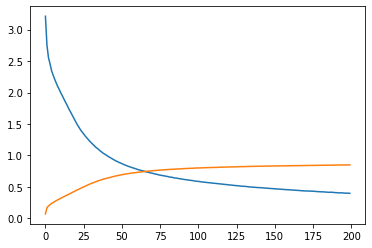

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

In [13]:
answer_vocab = answer_vectorization.get_vocabulary()
answer_index_lookup = dict(zip(range(len(answer_vocab)), answer_vocab))
max_decoded_sentence_length = 100


def decode_sequence(input_sentence):
    tokenized_input_sentence = question_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = answer_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = answer_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_questions = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_questions)
    solved = decode_sequence(input_sentence)
    print(input_sentence + '\n')
    print(solved + '\n')

At the local Pick Your Own fruit orchard, you could pick your own peaches for $2.00 per pound, plums were $1.00 per pound and apricots were $3.00 per pound.  If Winston picked 6 pounds of peaches, 8 pounds of plums and 6 pounds of apricots, how much did he spend on fruit?

[start] half the number of customers who were served coffee in the restaurant is 3525 [UNK] if the total number of customers who came in the restaurant is 25 then since the restaurant was 25 then then the number of customers in the restaurant was 25 x 2 2525050 customers in the restaurant was 75 [UNK] a total of the restaurant earned 75 [UNK] 95 [end]

Four friends ordered four pizzas for a total of 64 dollars. If two of the pizzas cost 30 dollars, how much did each of the other two pizzas cost if they cost the same amount?

[start] the cost of a single layer cake is 2000 bill so thats 15 5 1557575 the cost of the dough in the classroom and the classroom 600 x 100 180 x 20 [UNK] 20 [end]

On Monday, Walt walked 4 mil